In [167]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [168]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.metric.metric import Metric
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [169]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [170]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [171]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("index")
market.disconnect()
index = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",attrs={"id":"constituents"})[0].rename(columns={"Symbol":"ticker"})
index

,ticker,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [172]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [193]:
rolling_window = 20
market.connect()
prices = []
skips = 1
for ticker in tqdm(index["ticker"][::skips]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            dividends = market.query("dividends",{"ticker":ticker})
            if dividends.index.size > 0:
                dividends = p.utc_date(dividends)
                price = price.merge(dividends,on=["date","ticker"])
                price["dividend"] = price["rate"].ffill().fillna(0)
            else:
                price["dividend"] = 0
            price = Metric.DISTANCE.calculate(price,timeframe=rolling_window)
            price = Metric.NEXT_CLOSE.calculate(price,timeframe=rolling_window)
            price = Indicator.EMACorr.calculate(price,timeframe=rolling_window)
            price = RiskType.COEFFICIENT_OF_VARIATION.apply(price)
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [00:14<00:00, 34.05it/s]


In [194]:
model_end = 2024
backtest_end = 2025
simulation = pd.concat(prices)
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
simulation.sort_values("date", inplace=True)

In [195]:
portfolios = PortfolioSelection.generate_possible_portfolios(
                                                            ranking_metrics=[
                                                                "ema_corr"
                                                            ]
                                                            ,num_of_groups=[10]
                                                            ,group_percentages=[1]
                                                            ,max_prices=[1000]
                                                            ,min_prices=[1]
                                                            ,stoplosses=[0.05]
                                                            ,rolling_windows=[rolling_window]
                                                            ,leverages=[1,4]
                                                            )
filtered_portfolios = []
for portfolio in portfolios:
        if portfolio.timeframe.value == "day"  and "blacklist" in portfolio.selection_type.label  and portfolio.allocation_type.label == "risk" \
            and "distance" in portfolio.grouping_type.value   and portfolio.max_price > portfolio.min_price:
            filtered_portfolios.append(portfolio)
len(filtered_portfolios)

8

In [196]:
analysises = []
portfolio_value = 10
for portfolio in tqdm(filtered_portfolios):
    try:
        trades = portfolio.trades(simulation.copy())
        performance = portfolio.portfolio(trades.copy(),benchmark.copy())
        metrics = KPI.performance(trades,performance)
        results = {**portfolio.to_dict(),**metrics.copy()}
        results["portfolio"] = portfolio
        analysises.append(results)
    except Exception as e:
        print(str(e))
        continue

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:14<00:00,  1.76s/it]


In [197]:
a = pd.DataFrame(analysises)

In [198]:
metric = "raw_pnl"
dropped_columns = ["date","risk_type","timeframe","selection_percentage","stoploss","rolling_window","portfolio"]
filtered_a = a.drop(dropped_columns,axis=1).sort_values(metric,ascending=False)
top = a.sort_values(metric,ascending=False).head(20).to_dict("records")[0]
filtered_a.head(20)

,ranking_metric,position_type,grouping_type,selection_type,allocation_type,num_of_groups,max_price,min_price,leverage,pnl,raw_pnl,downside,coefficient_of_variation,portfolio_std,sharpe_ratio,tracking_error,information_ratio
5,ema_corr,long,DISTANCE,bottom_blacklist,risk,10,1000,1,4,2.720467,3.686064,0.854624,4.515637,0.602455,2.148383,0.483296,2.678075
3,ema_corr,short,DISTANCE,top_blacklist,risk,10,1000,1,4,1.767229,2.205256,0.899570,8.529397,0.207193,1.646127,0.156541,2.178761
4,ema_corr,long,DISTANCE,bottom_blacklist,risk,10,1000,1,1,1.347140,1.457891,0.963656,11.771812,0.114438,-0.690537,0.049261,-1.604190
2,ema_corr,short,DISTANCE,top_blacklist,risk,10,1000,1,1,1.204501,1.278067,0.974892,21.871280,0.055072,-4.024929,0.098474,-2.250973
0,ema_corr,long,DISTANCE,top_blacklist,risk,10,1000,1,1,0.941306,0.990772,0.963672,41.679646,0.022584,-21.468778,0.138833,-3.492389
6,ema_corr,short,DISTANCE,bottom_blacklist,risk,10,1000,1,1,0.894161,0.943358,0.966370,21.121051,0.042335,-12.566476,0.168459,-3.158061
1,ema_corr,long,DISTANCE,top_blacklist,risk,10,1000,1,4,0.659626,0.804423,0.854690,6.480617,0.101784,-7.530986,0.205486,-3.730372
7,ema_corr,short,DISTANCE,bottom_blacklist,risk,10,1000,1,4,0.530567,0.653240,0.865482,3.228623,0.164332,-5.449913,0.285882,-3.132746


In [199]:
# orivault.cloud_connect()
# orivault.drop("results")
# orivault.store("results",pd.DataFrame([top]).drop("portfolio",axis=1))
# orivault.disconnect()

In [200]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

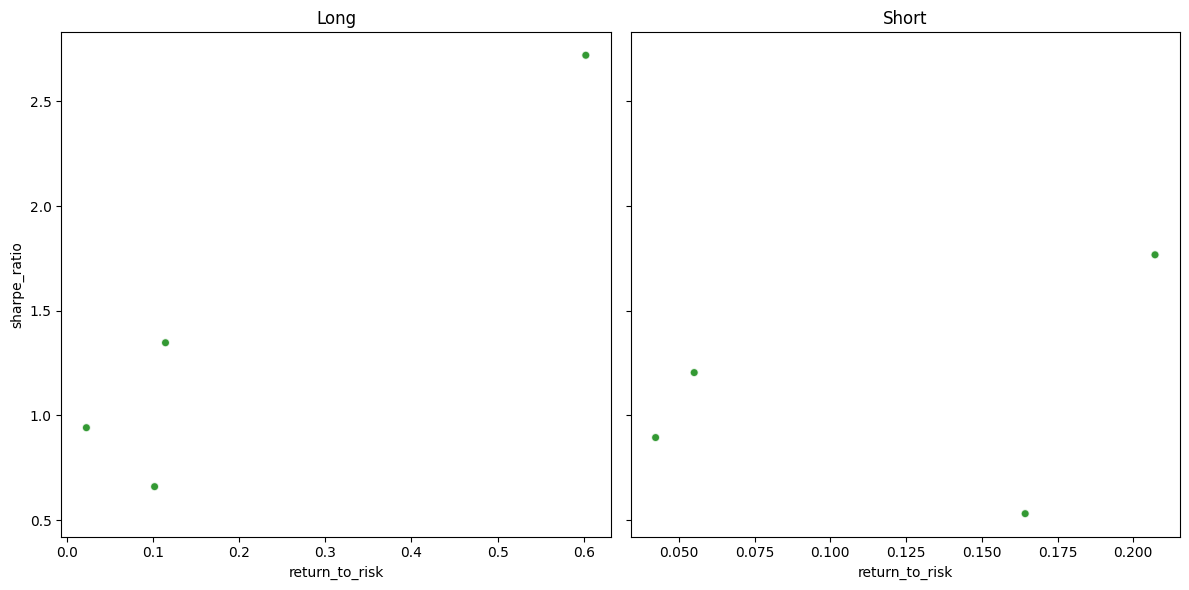

In [201]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [202]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy())
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

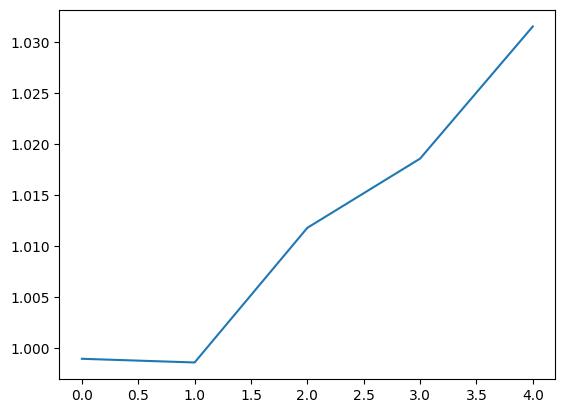

In [203]:
portfolio["weekday"] = portfolio["date"].dt.weekday
averaged_portfolio = portfolio.groupby("weekday").agg({"weighted_return":"mean","return":"mean"}).reset_index()
averaged_portfolio["pv"] = averaged_portfolio["weighted_return"].cumprod()
plt.plot(averaged_portfolio["pv"])
plt.show()

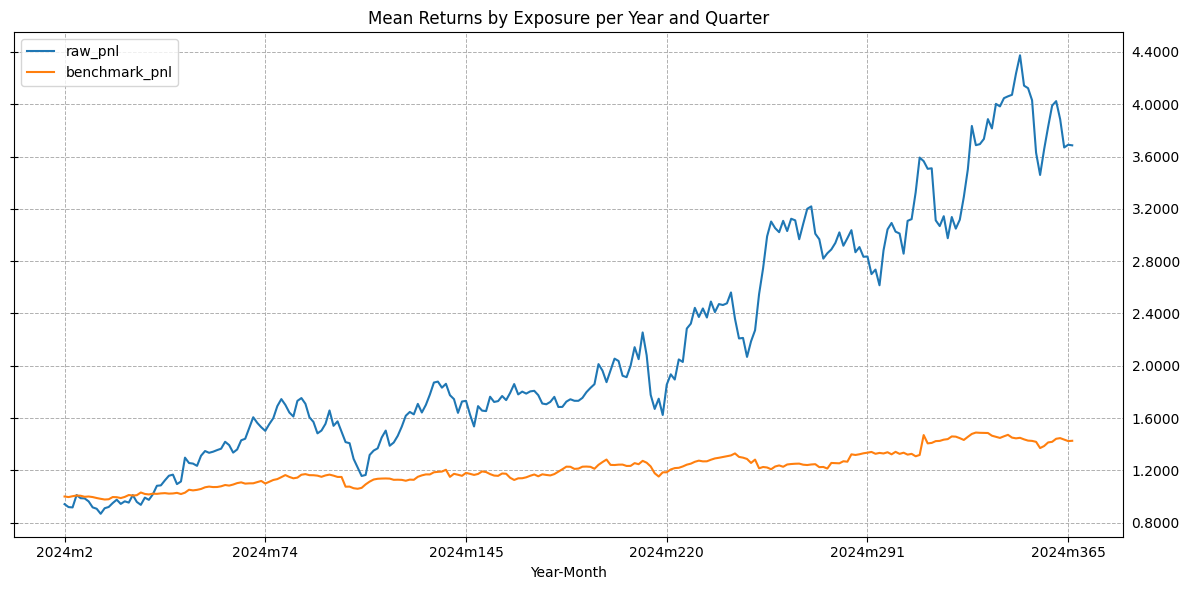

In [204]:
portfolio['Year-Month'] = portfolio["year"].astype(str) + "m" + portfolio[pm.timeframe.value].astype(str)
ax = portfolio[["Year-Month","raw_pnl","benchmark_pnl"]].set_index("Year-Month").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [205]:
trades[["ticker","return"]].groupby("ticker").mean().sort_values("return",ascending=False)

,return
ticker,
DVA,0.009448
BRK.B,0.008176
ORLY,0.007565
CBRE,0.007472
FFIV,0.004515
...,...
KEYS,-0.003395
SOLV,-0.003476
MHK,-0.003480


In [206]:
portfolio.sort_values("date")

,index,year,day,date,weighted_return,return,pnl,raw_pnl,benchmark,benchmark_pnl,month,quarter,week,weekday,Year-Month
0,0,2024,2,2024-01-02 00:00:00+00:00,0.941501,0.941501,0.941501,0.941501,166.11,1.000000,1,1,1,1,2024m2
1,1,2024,3,2024-01-03 00:00:00+00:00,0.976057,0.976057,0.918959,0.918959,165.39,0.995666,1,1,1,2,2024m3
2,2,2024,4,2024-01-04 00:00:00+00:00,0.997302,0.997302,0.916480,0.916480,166.48,1.002227,1,1,1,3,2024m4
3,3,2024,5,2024-01-05 00:00:00+00:00,1.103256,1.103256,1.011112,1.011112,167.32,1.007284,1,1,1,4,2024m5
4,4,2024,8,2024-01-08 00:00:00+00:00,0.976233,0.976233,0.987081,0.987081,167.07,1.005779,1,1,2,0,2024m8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,247,2024,359,2024-12-24 00:00:00+00:00,1.008618,1.008618,2.969991,4.024152,239.46,1.441575,12,4,52,1,2024m359
248,248,2024,361,2024-12-26 00:00:00+00:00,0.965528,0.965528,2.867610,3.885433,240.28,1.446511,12,4,52,3,2024m361
249,249,2024,362,2024-12-27 00:00:00+00:00,0.944449,0.944449,2.708310,3.669592,238.34,1.434832,12,4,52,4,2024m362
250,250,2024,365,2024-12-30 00:00:00+00:00,1.005729,1.005729,2.723826,3.690615,236.51,1.423816,12,4,1,0,2024m365


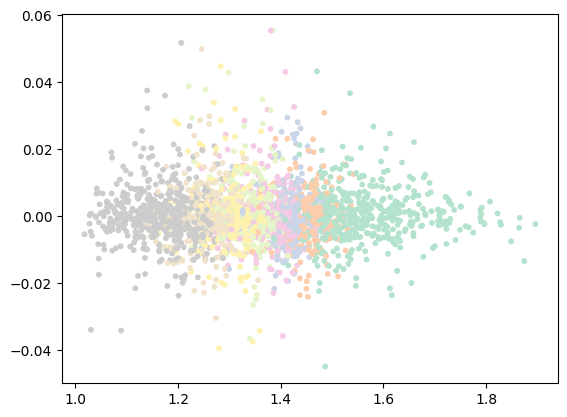

In [207]:
plt.scatter(trades["distance"],trades["return"],s=10,c=trades["group_percentile"].astype(int)*10,cmap="Pastel2")
plt.show()

In [208]:
trades.tail(20)

,year,day,ticker,date,adjclose,sell_price,distance,ema_corr,risk,group_percentile,...,position_type,weight,unweighted_return,stoploss_return,winsorized_return,weighted_return,return,month,quarter,week
2500,2024,99,AMD,2024-04-08 00:00:00+00:00,169.90,170.78,1.650127,-0.058681,0.051154,1,...,1.0,0.075343,1.005180,1.005180,1.005180,0.001561,0.001561,4,2,15
2501,2024,99,DAY,2024-04-08 00:00:00+00:00,62.55,64.10,1.195110,-0.081179,0.035255,10,...,1.0,0.109321,1.024780,1.024780,1.024780,0.010836,0.010836,4,2,15
2502,2024,99,MOH,2024-04-08 00:00:00+00:00,381.56,379.97,1.504488,-0.053567,0.038250,2,...,1.0,0.100762,0.995833,0.995833,0.995833,-0.001680,-0.001680,4,2,15
2503,2024,99,ULTA,2024-04-08 00:00:00+00:00,452.78,454.80,1.462469,-0.135769,0.075079,3,...,1.0,0.051334,1.004461,1.004461,1.004461,0.000916,0.000916,4,2,15
2504,2024,99,ON,2024-04-08 00:00:00+00:00,68.75,70.94,1.427922,-0.063496,0.051689,4,...,1.0,0.074563,1.031855,1.031855,1.031855,0.009501,0.009501,4,2,15
2505,2024,99,CHTR,2024-04-08 00:00:00+00:00,273.05,271.46,1.401155,-0.067607,0.034334,5,...,1.0,0.112252,0.994177,0.994177,0.994177,-0.002615,-0.002615,4,2,15
2506,2024,99,LULU,2024-04-08 00:00:00+00:00,360.46,358.80,1.375842,-0.142871,0.110194,6,...,1.0,0.034976,0.995395,0.995395,0.995395,-0.000644,-0.000644,4,2,15
2507,2024,99,WAT,2024-04-08 00:00:00+00:00,339.04,345.03,1.350605,-0.018091,0.017312,7,...,1.0,0.222623,1.017668,1.017668,1.017668,0.015733,0.015733,4,2,15
2508,2024,99,TSLA,2024-04-08 00:00:00+00:00,172.98,176.88,1.295836,-0.055190,0.028711,8,...,1.0,0.134237,1.022546,1.022546,1.022546,0.012106,0.012106,4,2,15
2509,2024,99,ENPH,2024-04-08 00:00:00+00:00,115.24,121.98,1.246731,-0.039234,0.045563,9,...,1.0,0.084588,1.058487,1.058487,1.058487,0.019789,0.019789,4,2,15
